Implementation of cGAN in Python, based on GAN implementation provided during the "Generative models" subject.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# sklearn imports
from sklearn.datasets import fetch_openml

# torch imports
from tqdm import tqdm
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


### Data

In [2]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self):
        super().__init__()
        # get the data
        X, y = fetch_openml(
            "mnist_784", version=1, return_X_y=True, as_frame=False
        )
        self.images = X.reshape((-1, 1, 28, 28)).astype("float32") / 127.5 - 1
        self.classes = torch.as_tensor(y.astype("int64"))
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.classes[idx]
        return image, label


    def __len__(self):
        return len(self.images)

### Models

#### Conditional Generative Adversarial Network
Tasks:
1. Adapt provided GAN to accept an additional conditional vector for the digit class
2. Train the conditional GAN on the MNIST dataset

In [16]:
latent_size = 100
device='cuda' if torch.cuda.is_available() else 'cpu'

In [63]:
# same as in GAN solution
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, dilation=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding="same", dilation=dilation)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding="same", dilation=dilation)
        self.bn2 = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        return self.bn2(self.conv2(self.leaky_relu(self.bn1(self.conv1(x)))))

    
# almost same as in GAN solution
class Encoder(nn.Module):
    def __init__(self, chs=(1, 2, 4)):
        super().__init__()
        self.chs = chs
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i + 1]) for i in range(len(chs) - 1)])
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x):
        for block in self.enc_blocks:
            x = block(x)
            x = self.pool(x)
        return x

# almost the same as in GAN - adjusted so that it includes labels
class Discriminator(nn.Module):
    def __init__(self, chs=(1, 2, 4),image_size=28, latent_size=60, num_classes=10,device='cpu'):
        super().__init__()
        self.chs = chs
        self.encoder = Encoder(chs)
        
        # added this for label embeddings 
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.linear_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(int(image_size*image_size/((len(self.chs)-1)*2))+self.label_emb.embedding_dim, latent_size),
            nn.ReLU(),
            nn.Linear(latent_size, 1),
            nn.Sigmoid(),
        )

    
    # added more steps
    def forward(self, x, labels, noise_factor=0.1):
        noise = torch.randn_like(x) * noise_factor
        x = x + noise
        x = self.encoder(x)
        
        # changing x shape
        x = x.view(x.size(0), -1)
        
        # adding label embeddings to x
        c = self.label_emb(labels)
        x = torch.cat([x, c], dim=1)
        return self.linear_head(x)


# same as in GAN
class Decoder(nn.Module):
    def __init__(self, chs=(4, 2, 1), latent_size=20,device='cpu'):
        super().__init__()
        self.chs = chs
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i], 2, 2) for i in range(len(chs) - 1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i + 1]) for i in range(len(chs) - 1)])

    def forward(self, x):
        for i in range(len(self.chs) - 1):
            x = self.upconvs[i](x)
            x = self.dec_blocks[i](x)
        return x


# almost the same as in GAN - adjusted so that it includes labels
class Generator(nn.Module):
    def __init__(self, chs=(4, 2, 1), latent_size=100, num_classes=10,device='cpu'):
        super().__init__()
        self.chs = chs
        self.decoder = Decoder(chs)
        
        # added for labels embedding
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.latent_linear = nn.Sequential(
            # here changed the size to include num_classes
            nn.Linear(latent_size + num_classes, chs[0]*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (chs[0], 7, 7)),
        )
        
        self.head = nn.Conv2d(chs[-1], 1, kernel_size=1, padding=0)
        self.tanh = nn.Tanh()
    
    # added more steps
    def forward(self, x, labels):
        
        # changing x and including labels
        x = x.view(x.size(0), -1)
        c = self.label_emb(labels)
        x = torch.cat([x, c], dim = 1)
        
        # running through latent linear & decoder
        x = self.decoder(self.latent_linear(x))
        x=self.tanh(x)
        # I don't know how to include those steps, all the time I had problems with shapes
        #x = self.head(x)
        #x = self.tanh(x)
 
        return x



Epoch: 1 - Training


100%|██████████| 2188/2188 [00:51<00:00, 42.17it/s]


gen loss 0.39635879272689545
disc loss 0.6319280385671412
Epoch: 2 - Training


100%|██████████| 2188/2188 [00:52<00:00, 41.97it/s]


gen loss 1.4394608659531847
disc loss 0.8938910510370566
Epoch: 3 - Training


100%|██████████| 2188/2188 [00:51<00:00, 42.27it/s]


gen loss 4.565934909763023
disc loss 0.7942031847357314
Epoch: 4 - Training


100%|██████████| 2188/2188 [00:51<00:00, 42.57it/s]


gen loss 4.964075427604549
disc loss 0.7921291876999726
Epoch: 5 - Training


100%|██████████| 2188/2188 [00:52<00:00, 42.01it/s]


gen loss 5.718198706070727
disc loss 0.721226044285232
Epoch: 6 - Training


100%|██████████| 2188/2188 [00:52<00:00, 41.81it/s]


gen loss 5.362569689641705
disc loss 0.6528378504803455
Epoch: 7 - Training


100%|██████████| 2188/2188 [00:52<00:00, 41.93it/s]


gen loss 3.698503466258319
disc loss 0.7640972301581878
Epoch: 8 - Training


100%|██████████| 2188/2188 [00:50<00:00, 43.20it/s]


gen loss 4.032446279713179
disc loss 0.6771260325335497
Epoch: 9 - Training


100%|██████████| 2188/2188 [00:52<00:00, 42.01it/s]


gen loss 4.357511387882546
disc loss 0.6859819502237728
Epoch: 10 - Training


100%|██████████| 2188/2188 [00:51<00:00, 42.12it/s]

gen loss 4.398969928895752
disc loss 0.7138668325962925


In [ ]:
def train_one_epoch(data, generator, discriminator:Discriminator, generator_opt, discriminator_opt, epoch,total_epochs,latent_size=100,device="cuda"):
    losses_gen = []
    losses_disc = []
    loss_fn = torch.nn.BCELoss()
    noise_decay = max(0.01, 0.2 - (epoch / total_epochs))

    tk0 = tqdm(data)
    for bidx, data in enumerate(tk0):
        real, labels = data[0], data[1]
        real=real.to(device)
        labels=labels.to(device)
        b_size = real.shape[0]

        # train the discriminator
        discriminator.zero_grad()

        # apply the discriminator to the real batch and calculate the loss
        real_d = discriminator(real, labels,noise_decay)

        err_real = loss_fn(real_d, torch.ones_like(real_d))
        err_real.backward()
        
        # appl the discriminator to the fake batch and calculate the loss
        # Generate batch of latent vectors and fake images
        noise = torch.randn(b_size, latent_size).to(device)
        
        fake_labels = torch.randint(0, 10, (b_size,)).to(device)

        fake = generator(noise, fake_labels)
        fake_d = discriminator(fake.detach(), fake_labels,noise_decay)
        
        err_fake = loss_fn(fake_d, torch.zeros_like(fake_d))
        err_fake.backward()

        # get the error and update the discriminator
        err_disc = err_real + err_fake
        discriminator_opt.step()

        # train the generator
        generator.zero_grad()

        # re-apply the discriminator, calculate the loss and run it backwards
        gen_d = discriminator(fake, fake_labels)
        err_gen = loss_fn(gen_d, torch.ones_like(gen_d))
        err_gen.backward()
        
        # Update G
        generator_opt.step()

        # update our loss log
        losses_gen.append(err_gen.item())
        losses_disc.append(err_disc.item())
    
    return np.asarray(losses_gen), np.asarray(losses_disc)


generator = Generator(device=device).to(device)
discriminator = Discriminator(device=device).to(device)


epochs = 10
lr = 10**-4
batch_size = 32

train_loader = DataLoader(MNISTDataset(), batch_size=batch_size, pin_memory=True, shuffle=True)

# get the optimizer
gen_opt = torch.optim.Adam(generator.parameters(), lr=lr*2)
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=lr*0.5)

# run the training
losses_gen = []
losses_disc = []

for epoch in range(epochs):
    print(f"Epoch: {epoch+1} - Training")
    
    # do the training
    loss_gen, loss_disc = train_one_epoch(train_loader, generator, discriminator, gen_opt, disc_opt,epoch,epochs,device=device)
    print(f"gen loss {np.mean(loss_gen)}")
    print(f"disc loss {np.mean(loss_disc)}")
    # gather losses
    losses_gen = loss_gen if losses_gen is None else np.concatenate((losses_gen, loss_gen))
    losses_disc = loss_disc if losses_disc is None else np.concatenate((losses_disc, loss_disc))

training is almost the same as in provided GAN solution, but adjusted to include prior knowledge - labels

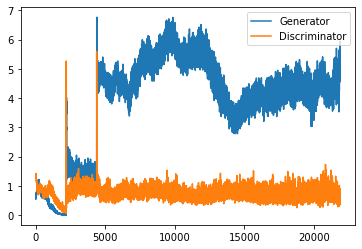

In [64]:
plt.plot(losses_gen, label="Generator")
plt.plot(losses_disc, label="Discriminator")
plt.legend()
plt.show()

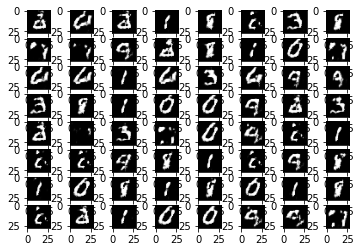

In [65]:
# generate some images
b_size = 64
with torch.no_grad():
    noise = torch.randn(b_size, latent_size).to(device)
    fake_labels = torch.randint(0, 10, (b_size,)).to(device)
    fake = generator(noise, fake_labels).to('cpu')

fig, axes = plt.subplots(8, 8)
for i in range(8):
    for j in range(8):
        axes[i, j].imshow(fake[i*8+j].squeeze(), cmap="gray")
plt.show()

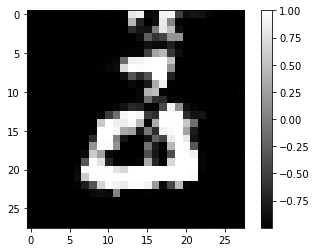

In [66]:
plt.imshow(fake[0, 0], cmap="gray")
plt.colorbar()
plt.show()

##### Interpolation in z-space

Choose a few pairs of z-vectors and interpolate between them. Keep the digit class constant. What changes, if anything?

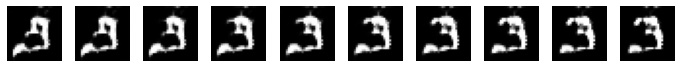

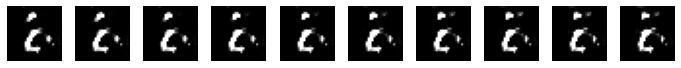

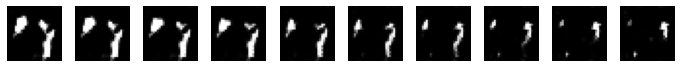

In [67]:
def interpolate_z(generator, z1, z2, labels, num_steps=2):
    interpolated_images = []

    for alpha in np.linspace(0, 1, num_steps):
        z_interpolated = alpha * z1 + (1 - alpha) * z2

        generated_image = generator(z_interpolated.unsqueeze(0), labels)
        interpolated_images.append(generated_image.squeeze().to('cpu').detach().numpy())

    return interpolated_images


generator.eval()

for _ in range(num_steps):
    z1 = torch.randn(latent_size).to(device)
    z2 = torch.randn(latent_size).to(device)
    label = torch.randint(0, 10, (1,)).to(device)

    interpolated_images = interpolate_z(generator, z1, z2, label)

    plt.figure(figsize=(12, 1))
    for i in range(len(interpolated_images)):
        plt.subplot(1, len(interpolated_images), i + 1)
        plt.imshow(interpolated_images[i], cmap='gray')
        plt.axis('off')
    plt.show()

    

##### Interpolate in label-space

Choose a few pairs of labels and interpolate between them. Keep the noise vector constant. What changes?

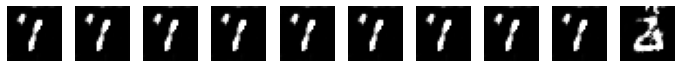

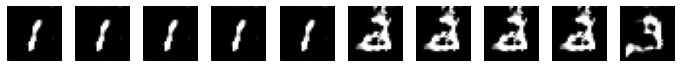

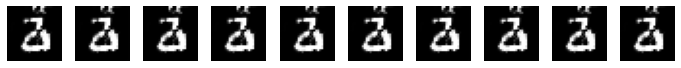

In [68]:
import numpy as np
import matplotlib.pyplot as plt


def interpolate_labels(generator, noise, label1, label2, num_steps=10):
    interpolated_images = []

    for alpha in np.linspace(0, 1, num_steps):
        interpolated_label = alpha * label1 + (1 - alpha) * label2
        interpolated_label = interpolated_label.long()

        repeated_label = interpolated_label.repeat(noise.size(0))
        
        generated_image = generator(noise, repeated_label)
        interpolated_images.append(generated_image.squeeze().to('cpu').detach().numpy())

    return interpolated_images

generator.eval()

for _ in range(3):
    noise = torch.randn(1, latent_size).to(device)
    label1 = torch.randint(0, 10, (1,)).to(device)
    label2 = torch.randint(0, 10, (1,)).to(device)

    interpolated_images = interpolate_labels(generator, noise, label1, label2)

    plt.figure(figsize=(12, 1))
    for i in range(len(interpolated_images)):
        plt.subplot(1, len(interpolated_images), i + 1)
        plt.imshow(interpolated_images[i], cmap='gray')
        plt.axis('off')
    plt.show()
